In [1]:
import Pkg
Pkg.activate(".")

  Activating project at `~/Bipropellant-Propulsion-System-Model/julia`


In [2]:
# Numerics
using DifferentialEquations, ModelingToolkit
# Display
using Plots

In [8]:
@parameters t
D = Differential(t)

(::Differential) (generic function with 3 methods)

In [48]:
R̄ = 8.314 # J/mol/K
# Flow connectors connect by making the sum zero
# Equality connectors connect by making the values equal #! This is the default behavior
# Stream connectors are for fluids
# https://discourse.julialang.org/t/modelingtoolkit-variable-metadata-for-connectors/92056/3
@connector FluidPort begin
    p(t) = 0.0
    T(t) = 0.0, [connect = Stream]
    ṁ(t) = 0.0, [connect = Flow]
end

@mtkmodel FluidElement begin
    @components begin
        port_a = FluidPort()
        port_b = FluidPort()
    end
    @variables begin
        dp(t) = 0.0 # Pa
        ṁ(t) = 0.0 # kg/s
    end
    @equations begin
        dp ~ port_a.p - port_b.p
        port_a.ṁ ~ ṁ
        port_a.ṁ + port_b.ṁ ~ 0
    end
end


@mtkmodel GasVolume begin
    @components begin
        port_a = FluidPort()
        port_b = FluidPort()
    end

    @parameters begin
        m_init = 1.0 # kg
        p_init = 1e5 # Pa
        T = 300.0 # K
        V = 1.0 # m^3
        molar_mass = 14e-3 # kg/mol
    end

    @variables begin
        m(t) = m_init
        p(t) = p_init
    end

    @equations begin
        # Mass balance
        D(m) ~ port_a.ṁ + port_b.ṁ
        p * V ~ m / molar_mass * R̄ * T

        # Connect to ports
        port_a.p ~ p
        port_a.T ~ T

        port_b.p ~ p
        port_b.T ~ T
    end
end

@mtkmodel LiquidVolume begin
    @components begin
        port_a = FluidPort()
        port_b = FluidPort()
    end

    @parameters begin
        m_init = 1.0 # kg
    end

    @variables begin
        m(t) = m_init
        p(t)
    end

    @equations begin
        D(m) ~ port_a.ṁ + port_b.ṁ

        port_a.p ~ p
        port_b.p ~ p
    end
end

@mtkmodel PressureInterface begin
    @extend ṁ, dp = element1d = FluidElement()
    @equations begin
        ṁ ~ 0
        dp ~ 0
    end
end

# TwoPhaseTank with a gas and liquid phase
# Pressure determined by the gas phase
@component function TwoPhaseVolume(; name, mass_L=1.0, mass_G=0.5, p_init=1e5)
    @named gas = GasVolume(m_init=mass_G, p_init=p_init)
    @named liquid = LiquidVolume(m_init=mass_L)
    @named interface = PressureInterface()

    sys = [
        gas,
        liquid,
        interface,
    ]
    eqs = [
        connect(gas.port_a, interface.port_a),
        connect(liquid.port_a, interface.port_b),
    ]
    ODESystem(eqs, t, [], []; name=name, systems=sys)
end

@mtkmodel FluidResistor begin
    @extend ṁ, dp = element1d = FluidElement()
    @parameters begin
        R = 1e-6 # 1 kg/s/MPa
    end
    @equations begin
        ṁ ~ dp * R
    end
end

@mtkmodel ThreeWayValve begin
    @components begin
        port_a = FluidPort()
        port_b = FluidPort()
        port_c = FluidPort()
    end
    @equations begin
        port_a.p ~ port_b.p
        port_a.p ~ port_c.p
        port_a.ṁ + port_b.ṁ + port_c.ṁ ~ 0
    end
end

@mtkmodel ConstPressure begin
    @components begin
        port = FluidPort()
    end
    @parameters begin
        p = 1e5 # Pa
    end
    @equations begin
        port.p ~ p
    end
end

@mtkmodel Nozzle begin
    @components begin
        port_a = FluidPort()
    end

    @parameters begin
        D_throat = 0.01
        γ = 1.3
        Tc = 2500.0
        R = 296.0 #! ihatethisihatethisihatethisihatethis
        A_throat = π * D_throat^2 / 4
        p_init = 1e5
    end

    @variables begin
        p(t) = p_init
    end

    @equations begin
        port_a.ṁ ~ p * A_throat / sqrt(Tc) * sqrt(γ / R) * ((γ + 1) / 2)^(-(γ + 1) / (2 * (γ - 1)))
        port_a.p ~ p
    end
end




ModelingToolkit.Model{typeof(__Nozzle__), Dict{Symbol, Any}}(__Nozzle__, Dict{Symbol, Any}(:components => [[:port_a, :FluidPort]], :variables => Dict{Symbol, Dict{Symbol, Any}}(:p => Dict(:default => :p_init)), :kwargs => Dict{Symbol, Any}(:γ => 1.3, :R => 296.0, :A_throat => :((π * D_throat ^ 2) / 4), :p => :p_init, :D_throat => 0.01, :p_init => 100000.0, :Tc => 2500.0), :independent_variable => t, :parameters => Dict{Symbol, Dict{Symbol, Any}}(:γ => Dict(:default => 1.3), :R => Dict(:default => 296.0), :A_throat => Dict(:default => :((π * D_throat ^ 2) / 4)), :D_throat => Dict(:default => 0.01), :p_init => Dict(:default => 100000.0), :Tc => Dict(:default => 2500.0)), :equations => ["port_a.ṁ ~ ((p * A_throat) / sqrt(Tc)) * sqrt(γ / R) *\n           ((γ + 1) / 2)^(-((γ + 1)) / (2 * (γ - 1)))", "port_a.p ~ p"]), false)

In [49]:
@named N2_tank = GasVolume(p_init=70e5, m_init=10.0)
@named N2_orifice = FluidResistor(R=1e-6)
@named N2_valve = ThreeWayValve()

@named N2O_inlet = FluidResistor(R=1e-6)
@named N2O_tank = TwoPhaseVolume(mass_L=1.0, mass_G=0.5, p_init=1e5)
@named N2O_orifice = FluidResistor(R=1e-6)

@named MeOH_inlet = FluidResistor(R=1e-6)
@named MeOH_tank = TwoPhaseVolume(mass_L=1.5, mass_G=0.1, p_init=1e5)
@named MeOH_orifice = FluidResistor(R=1e-6)

@named feed_valve = ThreeWayValve()
# @named engine = FluidResistor(R=1e-5)
@named engine = Nozzle(D_throat=0.01)
# @named atm = ConstPressure(p=1e5)

connections = [
    # N2
    connect(N2_tank.port_a, N2_orifice.port_a),
    connect(N2_orifice.port_b, N2_valve.port_a),
    # N2O
    connect(N2_valve.port_b, N2O_inlet.port_a),
    connect(N2O_inlet.port_b, N2O_tank.gas.port_a),
    connect(N2O_tank.liquid.port_b, N2O_orifice.port_a),
    # MeOH
    connect(N2_valve.port_c, MeOH_inlet.port_a),
    connect(MeOH_inlet.port_b, MeOH_tank.gas.port_a),
    connect(MeOH_tank.liquid.port_b, MeOH_orifice.port_a),
    # Engine
    connect(N2O_orifice.port_b, feed_valve.port_a),
    connect(MeOH_orifice.port_b, feed_valve.port_b),
    connect(feed_valve.port_c, engine.port_a),
    # connect(engine.port_b, atm.port),
]

@named model = ODESystem(connections, t,
    systems=[
        N2_tank,
        N2_orifice,
        N2_valve,
        N2O_inlet,
        N2O_tank,
        N2O_orifice,
        MeOH_inlet,
        MeOH_tank,
        MeOH_orifice,
        feed_valve,
        engine,
        atm,
    ],
)
sys = structural_simplify(model)
prob = ODEProblem(
    sys,
    ModelingToolkit.missing_variable_defaults(sys),
    (0, 10.0),
)
@time sol = solve(prob)

  6.104771 seconds (5.39 M allocations: 308.427 MiB, 1.70% gc time, 99.91% compilation time)


retcode: Success
Interpolation: specialized 4rd order "free" stiffness-aware interpolation
t: 12-element Vector{Float64}:
  0.0
  1.0e-6
  1.1e-5
  0.00011099999999999999
  0.0011109999999999998
  0.011110999999999996
  0.11111099999999996
  0.9075521812119297
  2.462822863445744
  4.5761116296399695
  7.287993324028718
 10.0
u: 12-element Vector{Vector{Float64}}:
 [10.0, 0.5, 1.0, 0.1, 1.5, 0.611672857142857, 0.0031598297305384937]
 [9.999998847917245, 0.5000005404099519, 0.9999999627886582, 0.10000061167280265, 1.500000034051509, 0.6116727481689781, 0.0031598357978473946]
 [9.999987327100989, 0.5000059445041751, 0.9999995906754227, 0.10000672839483565, 1.500000374566083, 0.6116716584312571, 0.003159896470876938]
 [9.999872120067304, 0.5000599849168839, 0.9999958695612964, 0.10006789501581363, 1.500003779660226, 0.6116607611608255, 0.0031605031952272886]
 [9.998720162610656, 0.5006003360950023, 0.9999586602427858, 0.10067950129434318, 1.5000378254421265, 0.6115517991336892, 0.00316656

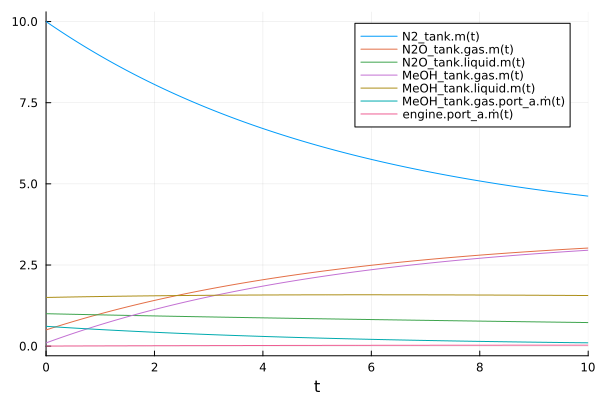

In [50]:
plot(sol)

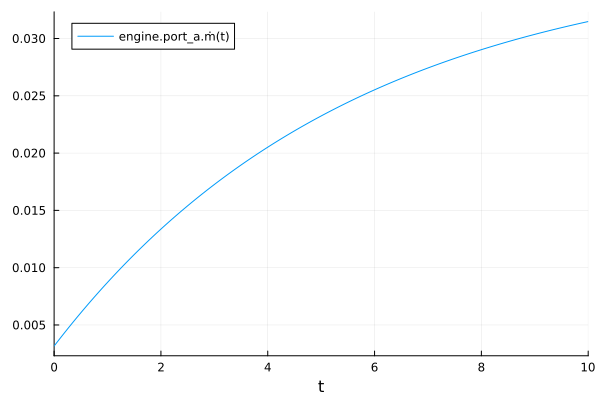

In [52]:
plot(sol, idxs = [engine.port_a.ṁ])

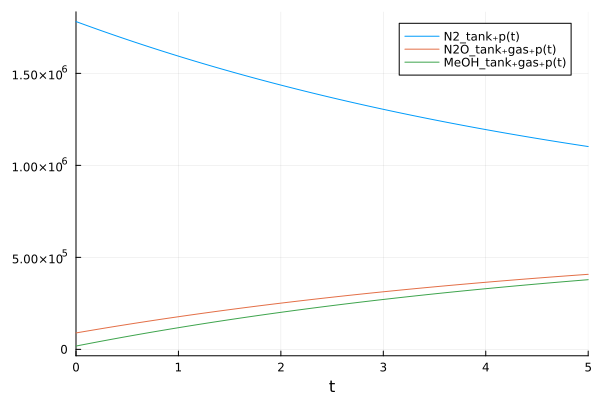

In [30]:
plot(sol, idxs = [N2_tank.p, N2O_tank.gas.p, MeOH_tank.gas.p])

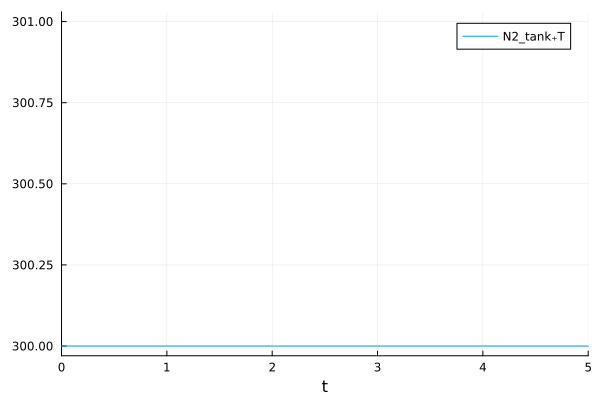

In [32]:
plot(sol, idxs = [N2_tank.T])